In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.optimize import linear_sum_assignment, linprog
from scipy import optimize
import sys
sys.path.append('../utils')

# Reload the module to get the latest changes
import importlib
if 'UCB_SW' in sys.modules:
    importlib.reload(sys.modules['UCB_SW'])

from UCB_SW import UCBSWAgent
from Multi_Thompson_constr_SW import MultiThompsonSamplingPricingAgentSW
from Multi_Thompson_constr import MultiThompsonSamplingPricingAgent

from Multi_Primal_Dual import MultiProductPrimalDualAgent
from UCB1_multi_constr import UCBMatchingAgent
from Multi_Thompson_constr_SW import MultiThompsonSamplingPricingAgentSW


In [10]:
np.random.seed(42)  # For reproducibility
T = 10000          # total time horizon
Inventory_frac = 0.8 
W = int(np.sqrt(T))   # sliding window size
W = int(np.sqrt(T)*5) # adjust according to the plots
print(f"Sliding window size: {W}")
n_products = 3
B = T * Inventory_frac * n_products  # total inventory across all products
n_intervals = 10
prices_per_product = 7
prices = np.linspace(0.1, 0.9, prices_per_product)

print(prices)

Sliding window size: 500
[0.1        0.23333333 0.36666667 0.5        0.63333333 0.76666667
 0.9       ]


# Slightly Non Stationary Environment

### We will simulate a slightly non-stationary environment by partitioning the rounds into intervals. The distribution in each intervall will be costant and at each intervall the mean and standard deviation will be incremented by a quantity sampled from a distribution


In [11]:
class NonStationaryEnvironment:
    def __init__(self, possible_prices, num_products, change_probability=0.01, mu_lim=(0.3,0.7), std_lim=(0.05,0.15), rng=None):
        """
        Initialize a non-stationary environment for pricing optimization.
        
        Args:
            possible_prices: Array of possible price points
            num_products: Number of products in the environment
            change_probability: Probability of parameter change at each timestep
            mu_lim: Tuple defining limits for mean valuations (min, max)
            std_lim: Tuple defining limits for standard deviations (min, max)
            rng: Random number generator instance
        """
        self.rng = rng if rng else np.random.default_rng()
        self.possible_prices = possible_prices
        self.num_products = num_products
        self.change_probability = change_probability
        self.mu_lim = mu_lim
        self.std_lim = std_lim

    def sample_parameters(self, T):
        """
        Sample mean and standard deviation parameters for each timestep.
        Creates piecewise constant distributions that change at random intervals.
        
        Args:
            T: Total number of timesteps
        """
        means_per_timestep = np.empty((T, self.num_products))
        stds_per_timestep = np.empty((T, self.num_products))

        # Determine when changes occur for each product at each timestep
        change_triggers = np.random.random(size=(T, self.num_products))
        change_mask = change_triggers < self.change_probability
        n_changes = np.sum(change_mask)
        
        # Sample initial parameters for each product
        starting_means = self.rng.uniform(low=self.mu_lim[0], high=self.mu_lim[1], size=self.num_products)
        starting_stds = self.rng.uniform(low=self.std_lim[0], high=self.std_lim[1], size=self.num_products)

        # Sample new parameters for all change events
        means = self.rng.uniform(low=self.mu_lim[0], high=self.mu_lim[1], size=n_changes)
        stds = self.rng.uniform(low=self.std_lim[0], high=self.std_lim[1], size=n_changes)

        # Get indices where changes occur
        change_timesteps, change_products = np.nonzero(change_mask)
        
        # Fill parameters for each product across all timesteps
        for product in range(self.num_products):
            product_mask = change_products == product
            if np.sum(product_mask) == 0:
                # No changes for this product - use starting values throughout
                means_per_timestep[:, product] = starting_means[product]
                stds_per_timestep[:, product] = starting_stds[product]
                continue
            
            # Get change points and new values for this product
            product_change_steps = change_timesteps[product_mask]
            product_means = means[product_mask]
            product_stds = stds[product_mask]
            
            # Fill initial period (before first change)
            means_per_timestep[:product_change_steps[0], product] = starting_means[product]
            stds_per_timestep[:product_change_steps[0], product] = starting_stds[product]
            
            # Fill periods between changes
            for i in range(len(product_change_steps) - 1):
                start_step = product_change_steps[i]
                end_step = product_change_steps[i+1]
                means_per_timestep[start_step:end_step, product] = product_means[i]
                stds_per_timestep[start_step:end_step, product] = product_stds[i]

            # Fill final period (after last change)
            means_per_timestep[product_change_steps[-1]:, product] = product_means[-1]
            stds_per_timestep[product_change_steps[-1]:, product] = product_stds[-1]
            
        # Store generated parameters
        self.means = means_per_timestep
        self.stds = stds_per_timestep

    def sample_valuation(self, t):
        """
        Sample customer valuations from normal distributions for timestep t.
        
        Args:
            t: Current timestep
            
        Returns:
            Clipped valuations in [0,1] range for current timestep only
        """
        # Sample valuations for current timestep only
        current_means = self.means[t]  # Shape: (num_products,)
        current_stds = self.stds[t]    # Shape: (num_products,)
        valuations = self.rng.normal(loc=current_means, scale=current_stds)
        return np.clip(valuations, 0, 1)

    def buyer_response(self, prices, valuations):
        """
        Determine buyer purchase decisions based on prices vs valuations.
        
        Args:
            prices: Array of prices for each product
            valuations: Array of customer valuations for each product
            
        Returns:
            Boolean array indicating purchases (True if valuation > price)
        """
        return (prices < valuations).astype(bool)

    def get_rewards(self, t, prices):
        """
        Get rewards for given prices at timestep t.
        
        Args:
            t: Current timestep
            prices: Array of prices for each product
            
        Returns:
            Array of rewards (price if purchased, 0 otherwise)
        """
        # Sample customer valuations for this timestep only
        valuations = self.sample_valuation(t)
        
        # Determine purchases and calculate rewards
        purchases = self.buyer_response(prices, valuations)
        rewards = prices * purchases
        
        return rewards

### Evolution of the mean and standard deviation during time

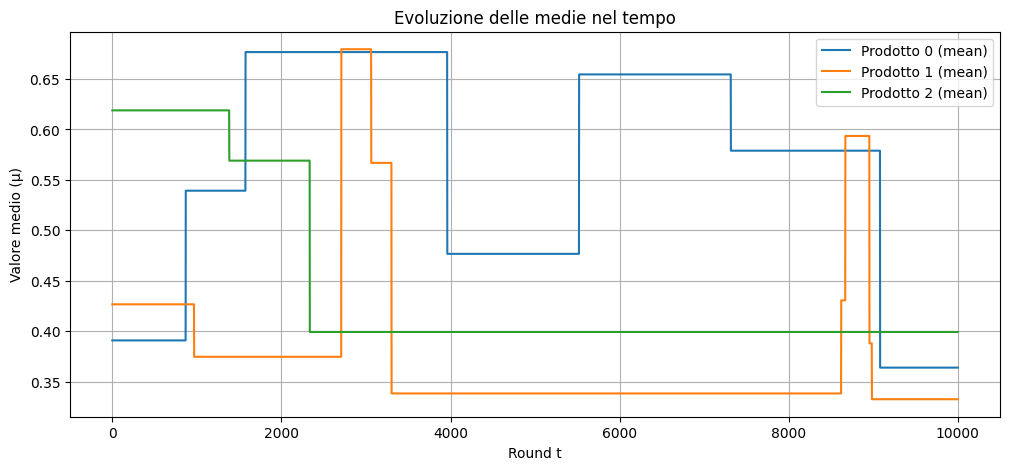

In [12]:
rng = np.random.default_rng(12345)
env = NonStationaryEnvironment(prices, n_products, change_probability=0.0003, rng=rng)
env.sample_parameters(T)

# Plot delle medie
plt.figure(figsize=(12,5))

for p in range(n_products):
    plt.plot(env.means[:, p], label=f"Prodotto {p} (mean)")

plt.title("Evoluzione delle medie nel tempo")
plt.xlabel("Round t")
plt.ylabel("Valore medio (μ)")
plt.legend()
plt.grid(True)
plt.show()


# Plot delle deviazioni standard
#plt.figure(figsize=(12,5))

#for p in range(n_products):
#    plt.plot(env.stds[p], label=f"Prodotto {p} (std)")

#plt.title("Evoluzione delle deviazioni standard nel tempo")
#plt.xlabel("Round t")
#plt.ylabel("Deviazione standard (σ)")
#plt.legend()
#plt.grid(True)
#plt.show()


Now we compare the performances of our learner with the baseline. The baseline knows the true expected reward of each arm

## Baseline

In [13]:
#Compute the revenue of the baseline strategy that knows the distribution of valuations
def baseline_revenue(env, B, T, precomputed_valuations=None):
     
    K = len(env.possible_prices)

    #Reward for every product at each timestep
    reward_history = np.full((T, env.num_products), 0.0)

    optimal_gamma = optimal_policy(env, B, T)
    inventory = B

    for t in range(T):
        #print("Step ",t , " in the optimal policy")
        if inventory < env.num_products:
            print(f"Inventory deployed at step {t}")
            break
        arms = np.empty(env.num_products, dtype=int)
        for product in range(env.num_products):
            #For every product sample a price (the index)
            arms[product] = np.random.choice(K, p = optimal_gamma[product])
       
        #Price selected for each product
        prices = env.possible_prices[arms]

        #Reward for each product at time t: if valuation > price -> reward = price, else 0
        if precomputed_valuations is not None:
            valuations = precomputed_valuations[t]
            purchases = env.buyer_response(prices, valuations)
            rewards = prices * purchases
        else:
            rewards = env.get_rewards(t, prices)

        #Inventory consumed
        inventory -= np.count_nonzero(rewards)

        reward_history[t] = rewards
    #Return the cumulative reward of each product overtime    
    return reward_history


#Compute the optimal policy knowing the true expected rewards and purchase probabilities
def optimal_policy(env, B, T):
    
    n = env.num_products
    K = len(env.possible_prices)

    #Compute true expected reward and demand probabilities for each product and price
    purchase_prob = np.zeros((T, n, K))

    for t in range(T):
         for i in range(n):
            for j in range(K):
                 #P(valuation > price) = 1 - CDF(price) for each product and for each timestep
                 purchase_prob[t,i,j] = 1 - norm.cdf(env.possible_prices[j], loc=env.means[t,i], scale=env.stds[t,i])

    #Compute the average purchase probability over time for each product and price
    avg_purchase_prob = purchase_prob.mean(axis=0)

    #Compute the expected reward for each product and price
    expected_rewards = np.zeros((n, K))
    for i in range(n):
         expected_rewards[i,:] = env.possible_prices * avg_purchase_prob[i,:]

    #Initialize the coefficient matrix for equality constraints
    A_eq = np.zeros((n, n*K))
    b_eq = np.ones(n)

    for dim in range(n):
        A_eq[dim,dim*K:(dim+1)*K] = 1

    c = -expected_rewards.flatten()
    A_ub = [avg_purchase_prob.flatten()]
    b_ub = [B/T]
    

    # Solve linear program
    try:
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq = b_eq,
                                bounds=(0,1))
        if res.success:
            gamma_flat = res.x
            # Reshape gamma back to (n_products, n_price_options)
            gamma = gamma_flat.reshape((n, K))

            # Ensure valid probability distribution for each product
            for product_idx in range(n):
                gamma[product_idx, :] = np.maximum(gamma[product_idx, :], 0)
                sum_gamma = np.sum(gamma[product_idx, :])
                if sum_gamma > 0:
                        gamma[product_idx, :] /= sum_gamma
                else:
                        # Fallback: uniform distribution for this product
                        gamma[product_idx, :] = np.ones(K) / K

            return gamma
        else:
            # Fallback: uniform distribution for all products
            return np.ones((n, K)) / K
    except Exception as e:
        print(f"LP Error: {e}")
        # Fallback: uniform distribution for all products
        return np.ones((n, K)) / K



## Initialize the enviroment and Run a simulation

In [14]:
# Initialize the environment
rng = np.random.default_rng(42)
env = NonStationaryEnvironment(prices, n_products, change_probability=0.001, rng=rng)
env.sample_parameters(T)

# Pre-generate valuations for consistent comparison later
np.random.seed(42)  # Reset seed for consistent valuation generation
precomputed_valuations_individual = np.zeros((T, env.num_products))
for t in range(T):
    precomputed_valuations_individual[t] = env.sample_valuation(t)

# Initialize the agent with improved inventory management
ag_UCB = UCBSWAgent(
    n_products=n_products, 
    price_options=prices, 
    inventory=B, 
    T=T, 
    window_size=W,
)

# Initialize the agent with improved inventory management
ag_SW = MultiThompsonSamplingPricingAgentSW(
    price_options=prices,
    window_size=W,
    alpha_prior=1.0,
    beta_prior=1.0,
    n_products=n_products,
    T=T,
    inventory=B
)

agents = {
    "UCB": ag_UCB,
    "Thompson": ag_SW
}

# total_reward = 0
reward_history = {}
inventory_consumed = {}
for agent_name, agent in agents.items():
    reward_history[agent_name] = np.zeros((T, env.num_products))
    inventory_consumed[agent_name] = 0

for t in range(T):
    if t % (T//10) == 0:
        for agent_name, agent in agents.items():
            print(f"Time step: {t}, Remaining inventory for {agent_name}: {agent.remaining_inventory}")

    # Agent selects a price for each product - returns (product_subset, prices)
    product_subset={}
    selected_prices={}

    for agent_name, agent in agents.items():
        subset, prices = agent.select_action()
        product_subset[agent_name] = subset
        selected_prices[agent_name] = prices
        if len(product_subset[agent_name]) == 0:
            print(f"Not enough inventory left for {agent_name} at time step {t}")
            print(f"Total inventory consumed: {inventory_consumed}")
            # Don't break here, continue with other agents

    # Create full price vector for all products
    price={
        "UCB": np.zeros(env.num_products),
        "Thompson": np.zeros(env.num_products)
    }
    for agent_name, agent in agents.items():
        if len(product_subset[agent_name]) > 0:  # Only if agent has inventory
            price[agent_name][product_subset[agent_name]] = selected_prices[agent_name]

    # Use precomputed valuations for consistency
    valuations = precomputed_valuations_individual[t]
    
    purchases={}
    f_t={}
    
    # Calculate purchases and rewards for each agent
    for agent_name, agent in agents.items():
        if len(product_subset[agent_name]) > 0:  # Only if agent has inventory
            purchases[agent_name] = env.buyer_response(price[agent_name], valuations)
            f_t[agent_name] = price[agent_name] * purchases[agent_name]
        else:
            purchases[agent_name] = np.zeros(env.num_products, dtype=bool)
            f_t[agent_name] = np.zeros(env.num_products)

    # Vector of the cost of the arm (which products were purchased)
    c_t={}
    for agent_name in agents.keys():
        if len(product_subset[agent_name]) > 0:  # Only if agent has inventory
            c_t[agent_name] = purchases[agent_name].astype(int)  # Convert boolean to int
            agent = agents[agent_name]
            
            # Count units sold
            units_sold = np.sum(c_t[agent_name])
            
            # Update inventory tracking
            inventory_consumed[agent_name] += units_sold
            
            # Store reward history
            reward_history[agent_name][t] = f_t[agent_name]
            
            # Update agent based on its interface
            if hasattr(agent, 'update') and 'Thompson' in agent_name:
                # For Thompson Sampling: update(products_purchased, total_revenue)
                products_purchased = [i for i, purchased in enumerate(c_t[agent_name]) if purchased]
                total_revenue = np.sum(f_t[agent_name])
                agent.update(products_purchased, total_revenue)
            else:
                # For UCB: update(rewards, costs)
                agent.update(f_t[agent_name], c_t[agent_name])
        else:
            # Agent has no inventory left
            c_t[agent_name] = np.zeros(env.num_products, dtype=int)
            reward_history[agent_name][t] = np.zeros(env.num_products)

print(f"Simulation completed. Total inventory consumed: {inventory_consumed}")

# Cumulative reward of each product over time and each agent
agent_cumulative_reward = {agent_name: history.cumsum(axis=0) for agent_name, history in reward_history.items()}

# Reward history of the baseline using the same precomputed valuations
baseline_reward_history = baseline_revenue(env, B, T, precomputed_valuations_individual)
baseline_cumulative_reward = baseline_reward_history.cumsum(axis=0)

for agent_name in agents.keys():
    print(f"Results for agent: {agent_name}")
    print(f"Agent total reward: {agent_cumulative_reward[agent_name][-1].sum():.2f}")
    print(f"Baseline total reward: {baseline_cumulative_reward[-1].sum():.2f}")
    print(f"Performance ratio: {agent_cumulative_reward[agent_name][-1].sum() / baseline_cumulative_reward[-1].sum():.3f}")
    print(f"Inventory utilization: {inventory_consumed[agent_name] / B:.3f}")

Time step: 0, Remaining inventory for UCB: 24000.0
Time step: 0, Remaining inventory for Thompson: 24000
Time step: 1000, Remaining inventory for UCB: 21695.0
Time step: 1000, Remaining inventory for Thompson: 21658
Time step: 2000, Remaining inventory for UCB: 19723.0
Time step: 2000, Remaining inventory for Thompson: 19773
Time step: 3000, Remaining inventory for UCB: 16976.0
Time step: 3000, Remaining inventory for Thompson: 17176


KeyboardInterrupt: 

# Plot of the cumulative rewards and regret

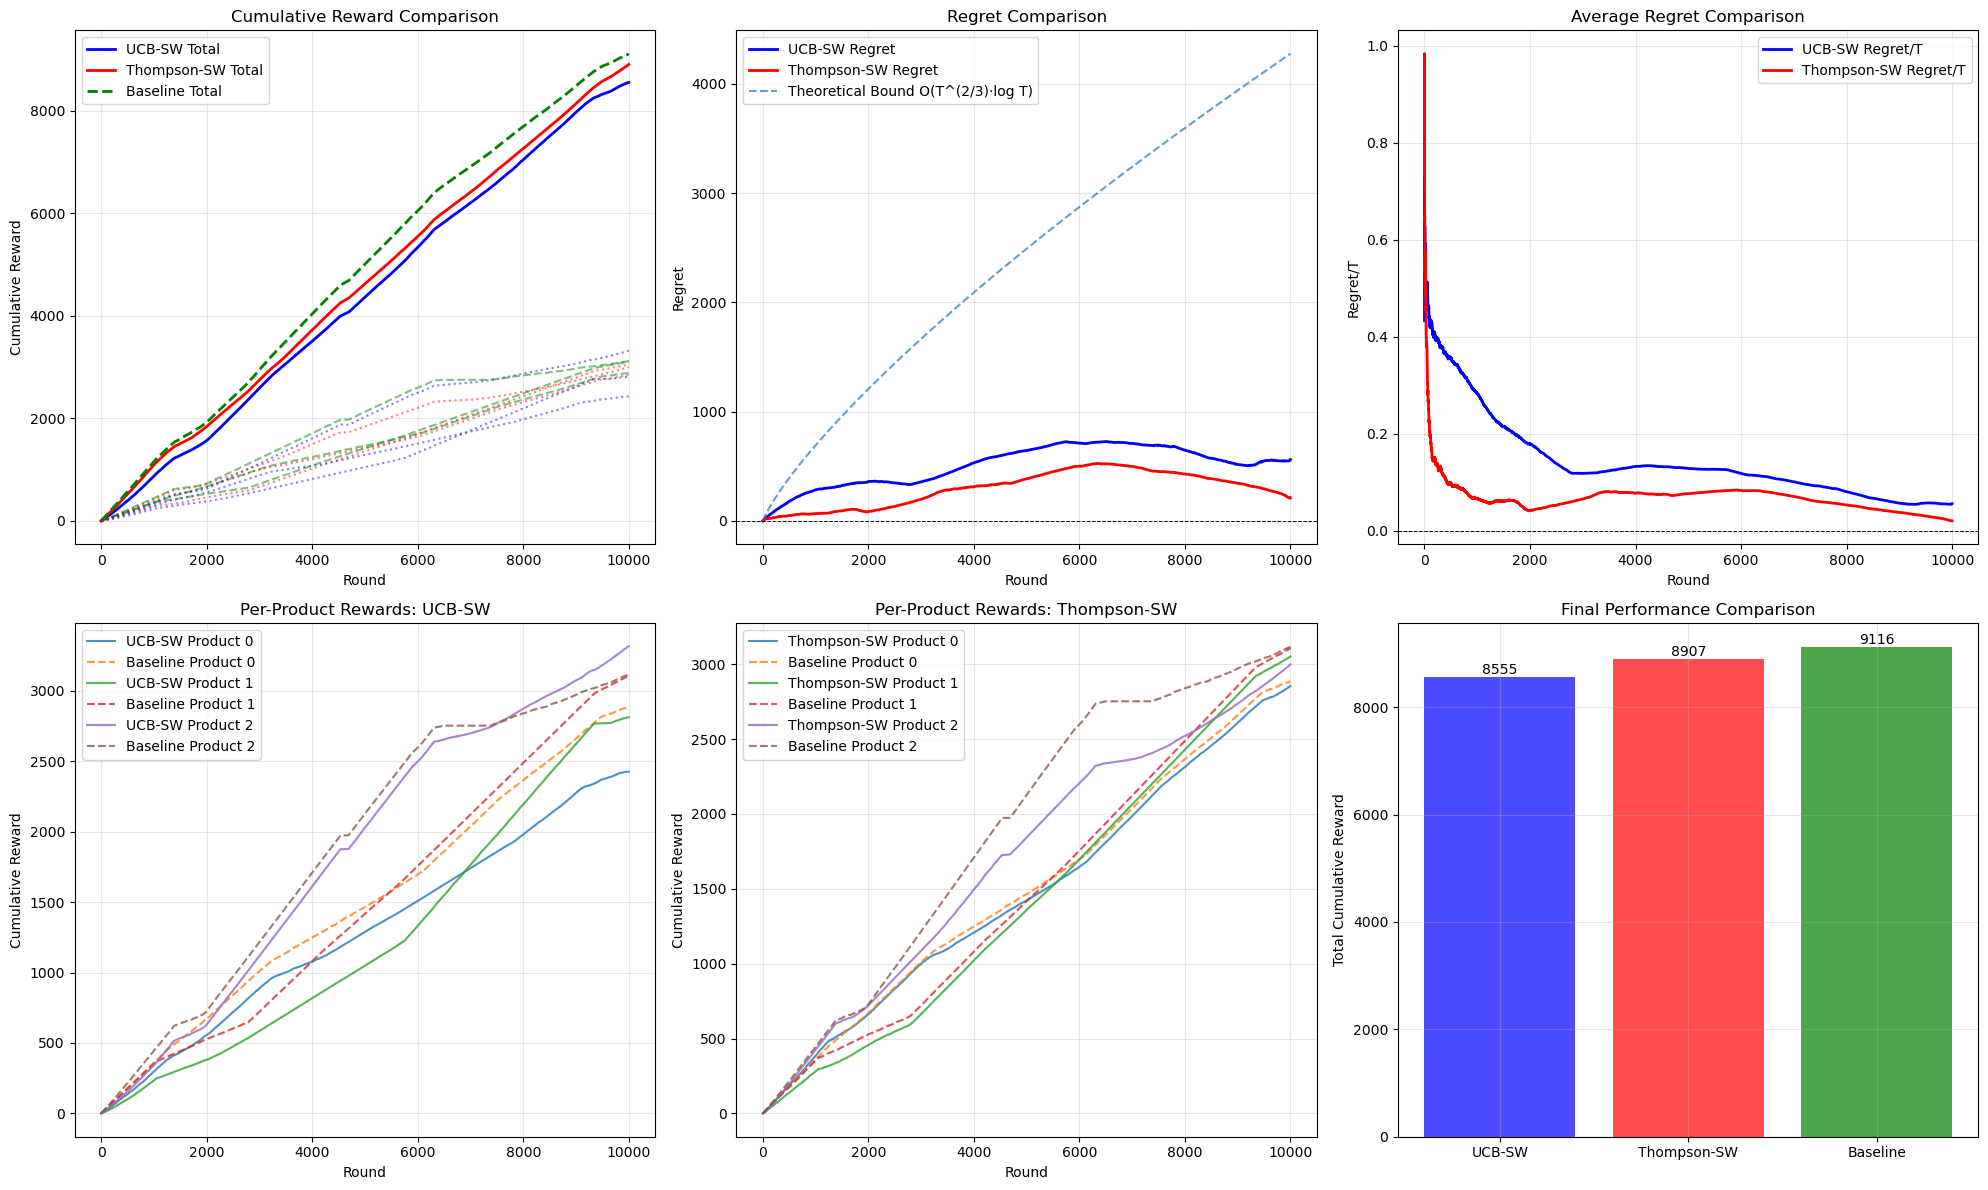


--- Performance Analysis ---
UCB-SW:
  Final regret: 560.83
  Final regret/T: 0.0561
  Theoretical bound ratio: 0.131

Thompson-SW:
  Final regret: 208.97
  Final regret/T: 0.0209
  Theoretical bound ratio: 0.049

Comparison:
  Thompson vs UCB regret difference: -351.87
  Thompson better by: 351.87
  Thompson vs UCB reward difference: 351.87
  Percentage difference: 4.11%


In [ ]:
# Plot results for both agents
plt.figure(figsize=(20, 12))

# Plot for UCB agent
ucb_cumulative = agent_cumulative_reward["UCB"]
ucb_regret = (baseline_cumulative_reward - ucb_cumulative).sum(axis=1)
theoretical_regret_ucb = [(t + 1)**(2/3) * np.log(t + 1) for t in range(len(ucb_regret))]

# Plot for Thompson agent  
thompson_cumulative = agent_cumulative_reward["Thompson"]
thompson_regret = (baseline_cumulative_reward - thompson_cumulative).sum(axis=1)
theoretical_regret_thompson = [(t + 1)**(2/3) * np.log(t + 1) for t in range(len(thompson_regret))]

# Subplot 1: Cumulative Rewards Comparison
plt.subplot(2, 3, 1)
plt.plot(ucb_cumulative.sum(axis=1), label='UCB-SW Total', linewidth=2, color='blue')
plt.plot(thompson_cumulative.sum(axis=1), label='Thompson-SW Total', linewidth=2, color='red')
plt.plot(baseline_cumulative_reward.sum(axis=1), label='Baseline Total', linestyle='--', linewidth=2, color='green')
for i in range(n_products):
    plt.plot(ucb_cumulative[:, i], alpha=0.5, color='blue', linestyle=':')
    plt.plot(thompson_cumulative[:, i], alpha=0.5, color='red', linestyle=':')
    plt.plot(baseline_cumulative_reward[:, i], alpha=0.5, color='green', linestyle='--')
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Regret Comparison  
plt.subplot(2, 3, 2)
plt.plot(ucb_regret, label="UCB-SW Regret", color='blue', linewidth=2)
plt.plot(thompson_regret, label="Thompson-SW Regret", color='red', linewidth=2)
plt.plot(theoretical_regret_ucb, label="Theoretical Bound O(T^(2/3)·log T)", linestyle="--", alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel("Round")
plt.ylabel("Regret")
plt.title("Regret Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Regret/T Comparison
plt.subplot(2, 3, 3)
t_vals = np.arange(len(ucb_regret)) + 1
plt.plot(ucb_regret/t_vals, label="UCB-SW Regret/T", color='blue', linewidth=2)
plt.plot(thompson_regret/t_vals, label="Thompson-SW Regret/T", color='red', linewidth=2)
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel("Round")
plt.ylabel("Regret/T")
plt.title("Average Regret Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 4: Per-Product UCB-SW
plt.subplot(2, 3, 4)
for i in range(n_products):
    plt.plot(ucb_cumulative[:, i], label=f"UCB-SW Product {i}", alpha=0.8)
    plt.plot(baseline_cumulative_reward[:, i], label=f"Baseline Product {i}", linestyle="--", alpha=0.8)
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("Per-Product Rewards: UCB-SW")
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 5: Per-Product Thompson-SW
plt.subplot(2, 3, 5)
for i in range(n_products):
    plt.plot(thompson_cumulative[:, i], label=f"Thompson-SW Product {i}", alpha=0.8)
    plt.plot(baseline_cumulative_reward[:, i], label=f"Baseline Product {i}", linestyle="--", alpha=0.8)
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("Per-Product Rewards: Thompson-SW")
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 6: Direct Performance Comparison
plt.subplot(2, 3, 6)
performance_data = {
    'UCB-SW': ucb_cumulative[-1].sum(),
    'Thompson-SW': thompson_cumulative[-1].sum(),
    'Baseline': baseline_cumulative_reward[-1].sum()
}
bars = plt.bar(performance_data.keys(), performance_data.values(), 
               color=['blue', 'red', 'green'], alpha=0.7)
plt.ylabel("Total Cumulative Reward")
plt.title("Final Performance Comparison")
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed comparison
print(f"\n--- Performance Analysis ---")
print(f"UCB-SW:")
print(f"  Final regret: {ucb_regret[-1]:.2f}")
print(f"  Final regret/T: {ucb_regret[-1]/T:.4f}")
print(f"  Theoretical bound ratio: {ucb_regret[-1]/theoretical_regret_ucb[-1]:.3f}")

print(f"\nThompson-SW:")
print(f"  Final regret: {thompson_regret[-1]:.2f}")
print(f"  Final regret/T: {thompson_regret[-1]/T:.4f}")
print(f"  Theoretical bound ratio: {thompson_regret[-1]/theoretical_regret_thompson[-1]:.3f}")

print(f"\nComparison:")
regret_diff = thompson_regret[-1] - ucb_regret[-1]
print(f"  Thompson vs UCB regret difference: {regret_diff:.2f}")
print(f"  Thompson better by: {-regret_diff:.2f}" if regret_diff < 0 else f"  UCB better by: {regret_diff:.2f}")

reward_diff = thompson_cumulative[-1].sum() - ucb_cumulative[-1].sum()
print(f"  Thompson vs UCB reward difference: {reward_diff:.2f}")
print(f"  Percentage difference: {(reward_diff/ucb_cumulative[-1].sum())*100:.2f}%")

# Comprehensive Comparison: UCB-SW vs UCB Multi-Constraint vs Multi-Product Primal-Dual

This section compares three different approaches for the multi-product pricing problem with inventory constraints in a slightly non-stationary environment:

1. **UCB-SW (UCB with Sliding Window)**: Handles non-stationarity by maintaining a sliding window of recent observations. Uses UCB confidence bounds within the window.

2. **UCB Multi-Constraint**: Uses combinatorial optimization (Linear Sum Assignment) to select the best combination of products and prices while respecting inventory constraints.

3. **Multi-Product Primal-Dual**: Uses a primal-dual approach with a dual variable λ that controls inventory consumption. Each product has its own learning algorithm (EXP3) and the rewards are adjusted by the Lagrangian to incorporate inventory costs.

Each algorithm has different theoretical properties and practical advantages for handling the trade-off between exploration, exploitation, and inventory management.

In [ ]:
def run_simulation(agent_class, agent_params, env, T, B, precomputed_valuations=None, description="Agent"):
    """
    Run a simulation with a specific agent and return the results.
    
    Args:
        agent_class: The agent class to instantiate
        agent_params: Dictionary of parameters for the agent
        env: The environment instance
        T: Time horizon
        B: Total inventory
        precomputed_valuations: Optional pre-computed valuations for consistent comparison
        description: Description for logging
    
    Returns:
        Dictionary with simulation results
    """
    print(f"\n--- Running simulation with {description} ---")
    
    # Initialize agent
    agent = agent_class(**agent_params)
    
    # Track results
    reward_history = np.zeros((T, env.num_products))
    inventory_consumed = 0
    
    for t in range(T):
        if t % (T//10) == 0:
            print(f"Time step: {t}, Remaining inventory: {agent.remaining_inventory}")
        
        # Agent selects action based on its interface
        if hasattr(agent, 'select_action') and 'UCBSWAgent' in str(type(agent)):  # UCB_SW interface
            product_subset, selected_prices = agent.select_action()
            if len(product_subset) == 0:
                print(f"Not enough inventory left at time step {t}")
                break
            
            # Create full price vector for all products
            prices = np.zeros(env.num_products)
            prices[product_subset] = selected_prices
            
            # Use precomputed valuations if available, otherwise sample from environment
            if precomputed_valuations is not None:
                valuations = precomputed_valuations[t]
                purchases = env.buyer_response(prices, valuations)
                rewards = prices * purchases
            else:
                rewards = env.get_rewards(t, prices)
            
            costs = (rewards != 0).astype(int)
            
            inventory_consumed += np.sum(costs)
            reward_history[t] = rewards
            agent.update(rewards, costs)
            
        elif hasattr(agent, 'select_action'):  # UCB_multi_constr interface
            product_subset, prices = agent.select_action()
            if len(product_subset) == 0:
                print(f"Not enough inventory left at time step {t}")
                break
            
            # Get rewards for selected products
            full_prices = np.zeros(env.num_products)
            full_prices[product_subset] = prices
            
            # Use precomputed valuations if available, otherwise sample from environment
            if precomputed_valuations is not None:
                valuations = precomputed_valuations[t]
                purchases = env.buyer_response(full_prices, valuations)
                full_rewards = full_prices * purchases
            else:
                full_rewards = env.get_rewards(t, full_prices)
            
            # Only consider rewards for selected products
            rewards = full_rewards[product_subset]
            products_purchased = [i for i, product_idx in enumerate(product_subset) if full_rewards[product_idx] > 0]
            
            # Convert to product indices that were actually purchased
            actual_purchased_products = [product_subset[i] for i in products_purchased]
            
            inventory_consumed += len(actual_purchased_products)
            reward_history[t] = full_rewards  # Store full reward vector
            
            agent.update(actual_purchased_products, np.sum(rewards))
            
        elif hasattr(agent, 'bid'):  # Primal-Dual interface
            prices = agent.bid()
            
            # Use precomputed valuations if available, otherwise sample from environment
            if precomputed_valuations is not None:
                valuations = precomputed_valuations[t]
                purchases = env.buyer_response(prices, valuations)
                rewards = prices * purchases
            else:
                rewards = env.get_rewards(t, prices)
                
            costs = (rewards != 0).astype(int)
            
            inventory_consumed += np.sum(costs)
            reward_history[t] = rewards
            
            # For primal-dual, we need to pass per-product revenue and purchases
            agent.update(costs, rewards)
    
    print(f"Simulation completed. Total inventory consumed: {inventory_consumed}")
    
    return {
        'reward_history': reward_history,
        'cumulative_reward': reward_history.cumsum(axis=0),
        'inventory_consumed': inventory_consumed,
        'agent': agent,
        'description': description
    }

# Simulation parameters
np.random.seed(42)  # For reproducibility

# Use the same environment as the individual UCB-SW simulation for fair comparison
env_comparison = env

# Use the same precomputed valuations as the individual simulation for consistency
precomputed_valuations = precomputed_valuations_individual

# Create price grid for primal-dual (it expects a 2D array)
prices_grid = np.tile(prices, (n_products, 1))

# Parameters for UCB-SW
ucb_sw_params = {
    'n_products': n_products,
    'price_options': prices,
    'inventory': B,
    'T': T,
    'window_size': W
}

# Parameters for UCB_multi_constr
ucb_multi_params = {
    'n_products': n_products,
    'price_options': prices,
    'inventory': B,
    'T': T,
    'selection_method': 'lsa'  # Use Linear Sum Assignment
}

# Parameters for Primal-Dual
eta = np.sqrt(np.log(prices_per_product) / T)  # Learning rate for primal-dual
primal_dual_params = {
    'prices_grid': prices_grid,
    'T': T,
    'P': int(B),
    'eta': eta,
    'lambda_init': 1.0,
    'algorithm': 'Exp3'  # Use EXP3 for bandit feedback
}

# Run simulations (using the same environment and precomputed valuations for fair comparison)
#results_ucb_sw = run_simulation(UCBSWAgent, ucb_sw_params, env_comparison, T, B, precomputed_valuations, "UCB-SW")
#results_ucb_multi = run_simulation(UCBMatchingAgent, ucb_multi_params, env_comparison, T, B, precomputed_valuations, "UCB Multi-Constraint")
results_primal_dual = run_simulation(MultiProductPrimalDualAgent, primal_dual_params, env_comparison, T, B, precomputed_valuations, "Multi-Product Primal-Dual")

# Thompson SW and Multi Thompson
thompson_sw_params = {
    'price_options': prices,
    'window_size': W,
    'alpha_prior': 1.0,
    'beta_prior': 1.0,
    'n_products': n_products,
    'T': T,
    'inventory': B
}

results_thompson_sw = run_simulation(MultiThompsonSamplingPricingAgentSW, thompson_sw_params, env_comparison, T, B, precomputed_valuations, "Thompson-SW")

thompson_params = {
    'price_options': prices,
    'alpha_prior': 1.0,
    'beta_prior': 1.0,
    'n_products': n_products,
    'T': T,
    'inventory': B
}

results_thompson_multi = run_simulation(MultiThompsonSamplingPricingAgent, thompson_params, env_comparison, T, B, precomputed_valuations, "Thompson Multi-Constraint")

# Get baseline results using the same precomputed valuations for consistency
baseline_reward_history_comp = baseline_revenue(env_comparison, B, T, precomputed_valuations)
baseline_cumulative_reward_comp = baseline_reward_history_comp.cumsum(axis=0)

print(f"\n--- Performance Comparison ---")
print(f"UCB-SW total reward: {results_ucb_sw['cumulative_reward'][-1].sum():.2f}")
print(f"UCB Multi-Constraint total reward: {results_ucb_multi['cumulative_reward'][-1].sum():.2f}")
print(f"Primal-Dual total reward: {results_primal_dual['cumulative_reward'][-1].sum():.2f}")
print(f"Baseline total reward: {baseline_cumulative_reward_comp[-1].sum():.2f}")
print(f"UCB-SW performance ratio: {results_ucb_sw['cumulative_reward'][-1].sum() / baseline_cumulative_reward_comp[-1].sum():.3f}")
print(f"UCB Multi-Constraint performance ratio: {results_ucb_multi['cumulative_reward'][-1].sum() / baseline_cumulative_reward_comp[-1].sum():.3f}")
print(f"Primal-Dual performance ratio: {results_primal_dual['cumulative_reward'][-1].sum() / baseline_cumulative_reward_comp[-1].sum():.3f}")
print(f"UCB-SW inventory utilization: {results_ucb_sw['inventory_consumed'] / B:.3f}")
print(f"UCB Multi-Constraint inventory utilization: {results_ucb_multi['inventory_consumed'] / B:.3f}")
print(f"Primal-Dual inventory utilization: {results_primal_dual['inventory_consumed'] / B:.3f}")


--- Running simulation with UCB-SW ---
Time step: 0, Remaining inventory: 24000.0
Time step: 1000, Remaining inventory: 21057.0
Time step: 2000, Remaining inventory: 18763.0
Time step: 3000, Remaining inventory: 15964.0


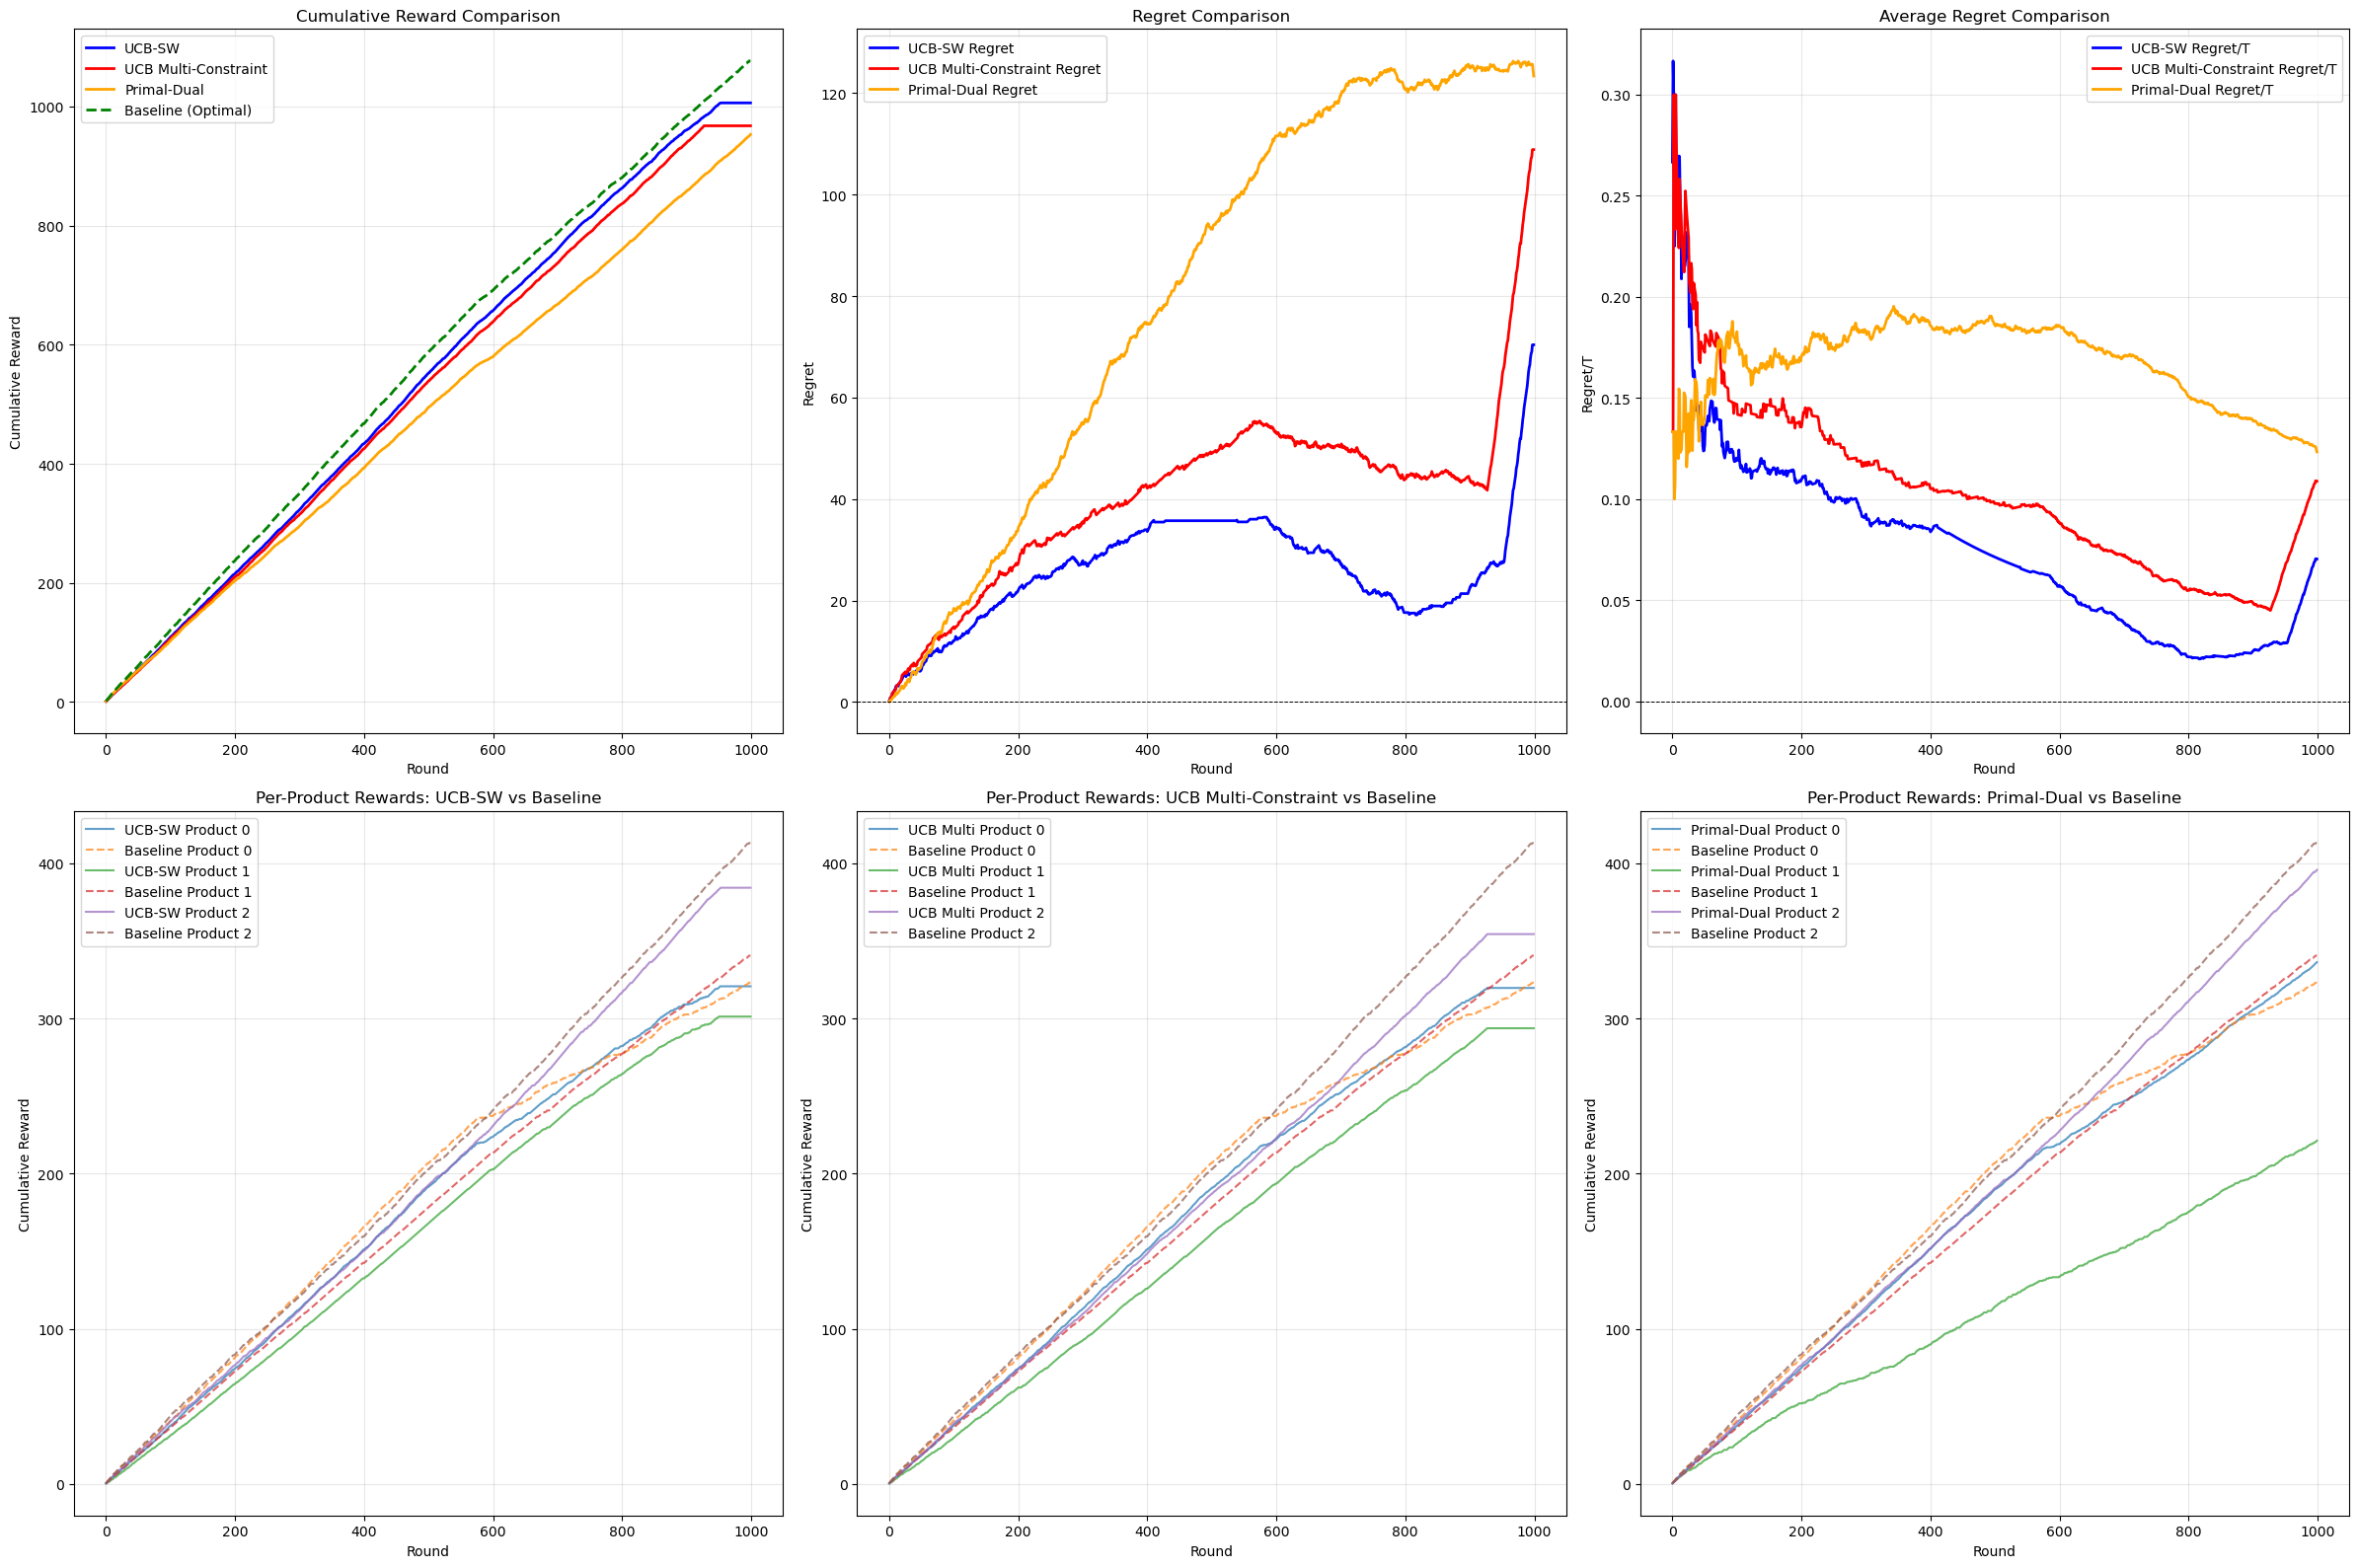


--- Detailed Performance Analysis ---
Final Regret:
  UCB-SW: 70.40
  UCB Multi-Constraint: 108.87
  Primal-Dual: 123.37

Final Regret/T:
  UCB-SW: 0.0704
  UCB Multi-Constraint: 0.1089
  Primal-Dual: 0.1234

Theoretical vs Actual Regret Ratios:
  UCB-SW: 0.102
  UCB Multi-Constraint: 1.310
  Primal-Dual: 1.484

Pairwise Revenue Comparisons:
  UCB Multi vs UCB-SW: -38.47
  Primal-Dual vs UCB-SW: -52.97
  Primal-Dual vs UCB Multi: -14.50

Percentage Improvements over UCB-SW:
  UCB Multi-Constraint: -3.82%
  Primal-Dual: -5.27%

Inventory Utilization Efficiency:
  UCB-SW: 1.000
  UCB Multi-Constraint: 1.001
  Primal-Dual: 0.944

Performance Ranking (by total reward):
  1. UCB-SW: 1006.00
  2. UCB Multi-Constraint: 967.53
  3. Primal-Dual: 953.03


In [ ]:
# Compute regrets for all three algorithms
regret_Thompson_sw = (baseline_cumulative_reward_comp - results_Thompson_sw['cumulative_reward']).sum(axis=1)
regret_Thompson_multi = (baseline_cumulative_reward_comp - results_Thompson_multi['cumulative_reward']).sum(axis=1)
regret_primal_dual = (baseline_cumulative_reward_comp - results_primal_dual['cumulative_reward']).sum(axis=1)

# Theoretical regret bounds
theoretical_regret_Thompson_sw = [(t + 1)**(2/3) * np.log(t + 1) for t in range(len(regret_Thompson_sw))]
theoretical_regret_Thompson_multi = [np.sqrt((t + 1) * np.log(t + 1)) for t in range(len(regret_Thompson_multi))]
theoretical_regret_primal_dual = [np.sqrt((t + 1) * np.log(t + 1)) for t in range(len(regret_primal_dual))]

# Create comprehensive comparison plots
plt.figure(figsize=(24, 16))

# Plot 1: Cumulative Rewards Comparison
plt.subplot(2, 3, 1)
plt.plot(results_Thompson_sw['cumulative_reward'].sum(axis=1), label='Thompson-SW', linewidth=2, color='blue')
plt.plot(results_Thompson_multi['cumulative_reward'].sum(axis=1), label='Thompson Multi-Constraint', linewidth=2, color='red')
plt.plot(results_primal_dual['cumulative_reward'].sum(axis=1), label='Primal-Dual', linewidth=2, color='orange')
plt.plot(baseline_cumulative_reward_comp.sum(axis=1), label='Baseline (Optimal)', linestyle='--', linewidth=2, color='green')
plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Regret Comparison
plt.subplot(2, 3, 2)
plt.plot(regret_Thompson_sw, label='Thompson-SW Regret', linewidth=2, color='blue')
plt.plot(regret_Thompson_multi, label='Thompson Multi-Constraint Regret', linewidth=2, color='red')
plt.plot(regret_primal_dual, label='Primal-Dual Regret', linewidth=2, color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Round')
plt.ylabel('Regret')
plt.title('Regret Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Regret/T Comparison
plt.subplot(2, 3, 3)
t_vals = np.arange(len(regret_Thompson_sw)) + 1
plt.plot(regret_Thompson_sw/t_vals, label='Thompson-SW Regret/T', linewidth=2, color='blue')
plt.plot(regret_Thompson_multi/t_vals, label='Thompson Multi-Constraint Regret/T', linewidth=2, color='red')
plt.plot(regret_primal_dual/t_vals, label='Primal-Dual Regret/T', linewidth=2, color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Round')
plt.ylabel('Regret/T')
plt.title('Average Regret Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Per-Product Cumulative Rewards (Thompson-SW)
plt.subplot(2, 3, 4)
for i in range(n_products):
    plt.plot(results_Thompson_sw['cumulative_reward'][:, i], label=f'Thompson-SW Product {i}', alpha=0.7)
    plt.plot(baseline_cumulative_reward_comp[:, i], label=f'Baseline Product {i}', linestyle='--', alpha=0.7)
plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('Per-Product Rewards: Thompson-SW vs Baseline')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Per-Product Cumulative Rewards (Thompson Multi-Constraint)
plt.subplot(2, 3, 5)
for i in range(n_products):
    plt.plot(results_Thompson_multi['cumulative_reward'][:, i], label=f'Thompson Multi Product {i}', alpha=0.7)
    plt.plot(baseline_cumulative_reward_comp[:, i], label=f'Baseline Product {i}', linestyle='--', alpha=0.7)
plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('Per-Product Rewards: Thompson Multi-Constraint vs Baseline')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Per-Product Cumulative Rewards (Primal-Dual)
plt.subplot(2, 3, 6)
for i in range(n_products):
    plt.plot(results_primal_dual['cumulative_reward'][:, i], label=f'Primal-Dual Product {i}', alpha=0.7)
    plt.plot(baseline_cumulative_reward_comp[:, i], label=f'Baseline Product {i}', linestyle='--', alpha=0.7)
plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('Per-Product Rewards: Primal-Dual vs Baseline')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed comparison statistics
print(f"\n--- Detailed Performance Analysis ---")
print(f"Final Regret:")
print(f"  Thompson-SW: {regret_Thompson_sw[-1]:.2f}")
print(f"  Thompson Multi-Constraint: {regret_Thompson_multi[-1]:.2f}")
print(f"  Primal-Dual: {regret_primal_dual[-1]:.2f}")

print(f"\nFinal Regret/T:")
print(f"  Thompson-SW: {regret_Thompson_sw[-1]/T:.4f}")
print(f"  Thompson Multi-Constraint: {regret_Thompson_multi[-1]/T:.4f}")
print(f"  Primal-Dual: {regret_primal_dual[-1]/T:.4f}")

print(f"\nTheoretical vs Actual Regret Ratios:")
print(f"  Thompson-SW: {regret_Thompson_sw[-1]/theoretical_regret_Thompson_sw[-1]:.3f}")
print(f"  Thompson Multi-Constraint: {regret_Thompson_multi[-1]/theoretical_regret_Thompson_multi[-1]:.3f}")
print(f"  Primal-Dual: {regret_primal_dual[-1]/theoretical_regret_primal_dual[-1]:.3f}")

print(f"\nPairwise Revenue Comparisons:")
print(f"  Thompson Multi vs Thompson-SW: {results_Thompson_multi['cumulative_reward'][-1].sum() - results_Thompson_sw['cumulative_reward'][-1].sum():.2f}")
print(f"  Primal-Dual vs Thompson-SW: {results_primal_dual['cumulative_reward'][-1].sum() - results_Thompson_sw['cumulative_reward'][-1].sum():.2f}")
print(f"  Primal-Dual vs Thompson Multi: {results_primal_dual['cumulative_reward'][-1].sum() - results_Thompson_multi['cumulative_reward'][-1].sum():.2f}")

print(f"\nPercentage Improvements over Thompson-SW:")
Thompson_sw_total = results_Thompson_sw['cumulative_reward'][-1].sum()
print(f"  Thompson Multi-Constraint: {((results_Thompson_multi['cumulative_reward'][-1].sum() - Thompson_sw_total) / Thompson_sw_total * 100):.2f}%")
print(f"  Primal-Dual: {((results_primal_dual['cumulative_reward'][-1].sum() - Thompson_sw_total) / Thompson_sw_total * 100):.2f}%")

print(f"\nInventory Utilization Efficiency:")
print(f"  Thompson-SW: {results_Thompson_sw['inventory_consumed'] / B:.3f}")
print(f"  Thompson Multi-Constraint: {results_Thompson_multi['inventory_consumed'] / B:.3f}")
print(f"  Primal-Dual: {results_primal_dual['inventory_consumed'] / B:.3f}")

# Performance ranking
performance_ranking = sorted([
    ('Thompson-SW', results_Thompson_sw['cumulative_reward'][-1].sum()),
    ('Thompson Multi-Constraint', results_Thompson_multi['cumulative_reward'][-1].sum()),
    ('Primal-Dual', results_primal_dual['cumulative_reward'][-1].sum())
], key=lambda x: x[1], reverse=True)

print(f"\nPerformance Ranking (by total reward):")
for i, (name, reward) in enumerate(performance_ranking, 1):
    print(f"  {i}. {name}: {reward:.2f}")